In [46]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import json
from tqdm import tqdm
import yaml

#import geopandas as gpd
import pandas as pd

import torch

import sys
sys.path.append('../')

import utils.basics as bsc 
import utils.plotting as pt
import utils.processing as proc
import utils.eval_pipe as eval

import utils.model_loader as md
import utils.data_loader as dt
import utils.config_loader as cf

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## For Loop first 6 experiments

In [ ]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[:6]  # Select the first 6 experiment names

with open('../configs/normparams.yaml', 'r') as f:
    normparams = yaml.safe_load(f)
joint_normparams = normparams['chm']['_111']


In [40]:
experiment_names

['baseline', 'pixel_composites']

In [64]:
for exp_name in experiment_names:

    sites, cfg = cf.get_config(exp_name)  
    global_config = md.global_config
    print("=== NEW EXPERIMENT ===")
    print(f" --> Name: {exp_name}")
    # Build dataset
    X, Y = dt.build_patched_dataset(cfg, sites, patch_size=32)
    # split into train/val/test (70/15/15) with your logic
    (X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = dt.split_dataset(X, Y)

    # Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
    train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
    val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
    test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

    train_loader = md.DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
    val_loader = md.DataLoader(val_dataset, batch_size=global_config['batch_size'])
    test_loader = md.DataLoader(test_dataset, batch_size=global_config['batch_size'])
    print(f"Train dataset valid pixel share: \t{train_dataset.validshare():.4f}, count: {len(train_dataset)}")
    print(f"Validation dataset valid pixel share: \t{val_dataset.validshare():.4f}, count: {len(val_dataset)}")
    print(f"Test dataset valid pixel share: \t{test_dataset.validshare():.4f}, count: {len(test_dataset)}")

    break
    # build model depending on in out channels, defined by the dataloaders
    model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
    #train model depending on config. 
    model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

    md.save_results(model, val_loader, test_loader, joint_normparams, logs, cfg)

    eval.plot_val_loss(logs['train_loss'],logs['val_loss'], title=exp_name)
    print("Minimum Validation Loss: ", min(logs['val_loss']))
    print("DONE WITH ", exp_name)
    print("==========")



=== NEW EXPERIMENT ===
 --> Name: baseline
Train dataset valid pixel share: 	0.9901, count: 820
Validation dataset valid pixel share: 	0.9913, count: 176
Test dataset valid pixel share: 	0.9918, count: 176


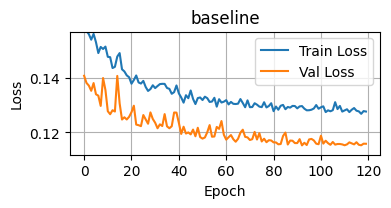

In [55]:
    eval.plot_val_loss(logs['train_loss'],logs['val_loss'], title=exp_name)

In [63]:
#X has the shape (1172, 14, 32, 32). i want the nan share across the second dimension (14)
nan_share = np.isnan(X).mean(axis=(0, 2, 3))*100
print(nan_share)

[3.16632892e-03 2.91635559e-03 1.41651557e-02 2.91635559e-03
 5.93270051e-02 1.52483735e-02 2.91635559e-03 2.99968003e-03
 2.91635559e-03 2.91635559e-03 3.41630226e-03 2.91635559e-03
 2.91635559e-03 1.40582505e+01]


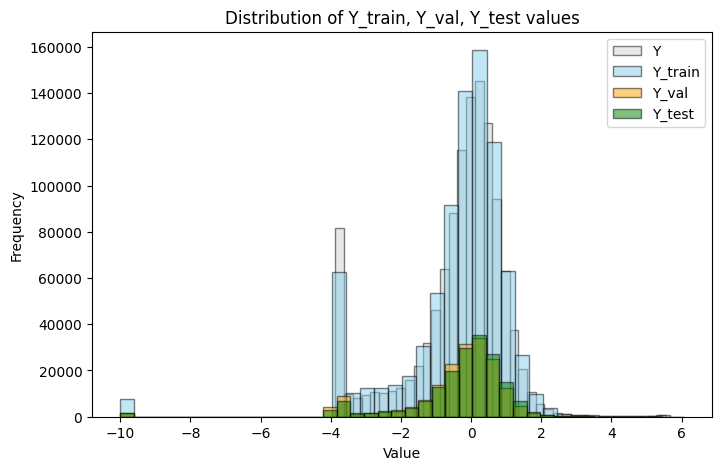

In [44]:
plt.figure(figsize=(8, 5))

plt.hist(Y.flatten(), bins=40, alpha=0.5, label='Y', color='lightgray', edgecolor='black')
plt.hist(Y_train.flatten(), bins=40, alpha=0.5, label='Y_train', color='skyblue', edgecolor='black')
plt.hist(Y_val.flatten(), bins=40, alpha=0.5, label='Y_val', color='orange', edgecolor='black')
plt.hist(Y_test.flatten(), bins=40, alpha=0.5, label='Y_test', color='green', edgecolor='black')

plt.title("Distribution of Y_train, Y_val, Y_test values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [15]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[3:4]  # Select the first 6 experiment names

with open('../configs/normparams.yaml', 'r') as f:
    normparams = yaml.safe_load(f)
joint_normparams = normparams['chm']['_111']

In [252]:
experiment_names

['pixel_and_seasonal']

Epochs: 100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


Results saved to: ../results/train/pixel_and_seasonal


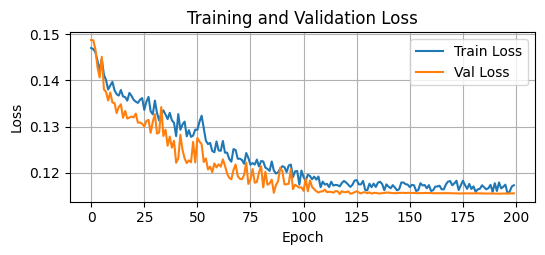

Minimum Validation Loss:  0.11542774889713679
DONE WITH  pixel_and_seasonal


In [254]:

for exp_name in experiment_names:
    sites, cfg = get_config(exp_name)  
    global_config = md.global_config

    # Build dataset
    X, Y = build_patched_dataset(cfg, sites, patch_size=32)
    # split into train/val/test (70/15/15) with your logic
    (X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

    # Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
    train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
    val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
    test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

    train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
    test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

    # build model depending on in out channels, defined by the dataloaders
    model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
    #train model depending on config. 
    model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

    md.save_results(model, val_loader, test_loader, joint_normparams, logs, cfg)
    eval.plot_val_loss(logs['train_loss'],logs['val_loss'])
    print("Minimum Validation Loss: ", min(logs['val_loss']))
    print("DONE WITH ", exp_name)
    print("==========")



# individual tests, to be cleared

## 1st experiment: BASELINE

In [183]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("baseline")  
global_config = md.global_config

with open('../configs/normparams.yaml', 'r') as f:
    normparams = yaml.safe_load(f)
joint_normparams = normparams['chm']['_111']

In [ ]:
# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = S2CanopyHeightDataset(X_val, Y_val)
test_dataset = S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

In [146]:
# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Epochs: 100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


In [148]:
md.save_results(model, logs, cfg)

Results saved to: ../results/train/baseline


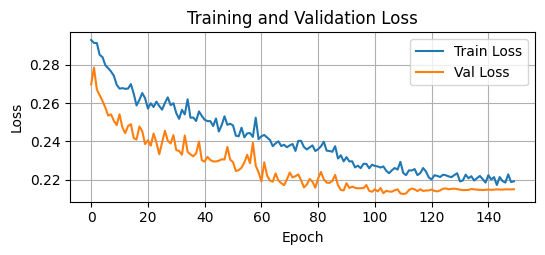

In [147]:
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])

## 2nd Experiment: + PIXEL COMPOSITES Q25, Q50, Q75

In [149]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("pixel_composites")  
global_config = md.global_config

# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = S2CanopyHeightDataset(X_val, Y_val)
test_dataset = S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Epochs: 100%|██████████| 150/150 [02:34<00:00,  1.03s/it]


Results saved to: ../results/train/pixel_composites


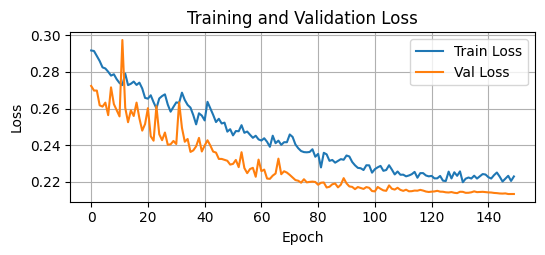

In [150]:
md.save_results(model, logs, cfg)
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])


In [151]:
print("Minimum Validation Loss: ", min(logs['val_loss']))

Minimum Validation Loss:  0.2132713171568784


In [152]:
X.shape

(1172, 40, 32, 32)

## 3rd experiment: seasonal_composites

In [153]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("seasonal_composites")  
global_config = md.global_config

# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Epochs: 100%|██████████| 150/150 [02:33<00:00,  1.02s/it]


Results saved to: ../results/train/seasonal_composites


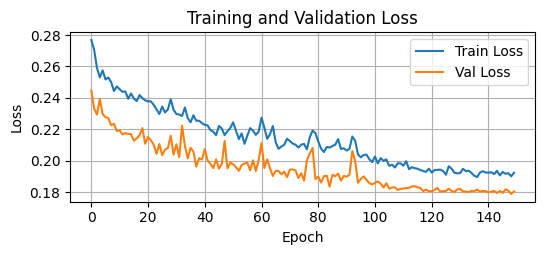

Minimum Validation Loss:  0.17872493618573898


In [ ]:
md.save_results(model, logs, cfg)
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])
print("Minimum Validation Loss: ", min(logs['val_loss']))

## 4th experiment: pixel_and_seasonal

In [155]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("pixel_and_seasonal")  
global_config = md.global_config

print("Loading dataset...")
# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

print("Building data-loaders...")
# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

print("Training ...")
# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Loading dataset...
Building data-loaders...
Training ...


Epochs: 100%|██████████| 150/150 [02:43<00:00,  1.09s/it]


Results saved to: ../results/train/pixel_and_seasonal


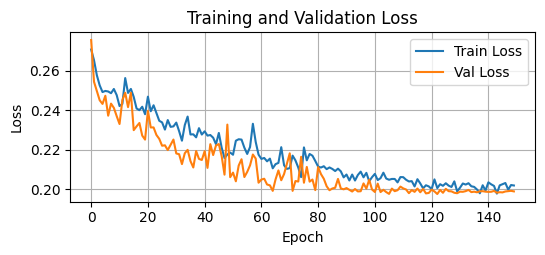

Minimum Validation Loss:  0.19751727198943114


In [156]:
md.save_results(model, logs, cfg)
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])
print("Minimum Validation Loss: ", min(logs['val_loss']))

## 5th experiment: pixel_and_seasonal + all aux

In [157]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("all_aux_data")  
global_config = md.global_config

print("Loading dataset...")
# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

print("Building data-loaders...")
# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

print("Training ...")
# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Loading dataset...
Building data-loaders...
Training ...


Epochs: 100%|██████████| 150/150 [02:40<00:00,  1.07s/it]


Results saved to: ../results/train/all_aux_data


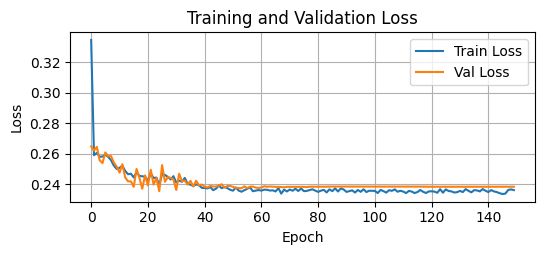

Minimum Validation Loss:  0.23547424108554155


In [158]:
md.save_results(model, logs, cfg)
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])
print("Minimum Validation Loss: ", min(logs['val_loss']))

## 6th experiment: Mid-Level-Learning

In [ ]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("mid_level_learning")  
global_config = md.global_config

print("Loading dataset...")
# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

print("Building data-loaders...")
# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

print("Training ...")
# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

In [ ]:
#model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Epochs: 100%|██████████| 150/150 [02:16<00:00,  1.10it/s]


In [186]:
test_loader

Results saved to: ../results/train/baseline


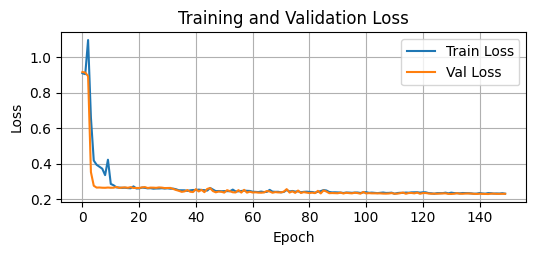

Minimum Validation Loss:  0.22883993050744456


In [197]:
md.save_results(model, val_loader, test_loader, joint_normparams, logs, cfg)
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])
print("Minimum Validation Loss: ", min(logs['val_loss']))

{'chm': {'_001': {'mu': 29.136810302734375, 'n': 424127, 'std': 5.059319972991943}, '_010': {'mu': 27.330501556396484, 'n': 331027, 'std': 6.319406986236572}, '_011': {'mu': 28.345002320026218, 'n': 755154, 'std': 5.611687865810269}, '_100': {'mu': 29.79595947265625, 'n': 753596, 'std': 9.429980278015137}, '_101': {'mu': 29.5585836550901, 'n': 1177723, 'std': 7.85599807406007}, '_110': {'mu': 29.043501579318452, 'n': 1084623, 'std': 8.480633136144107}, '_111': {'mu': 29.069731736028462, 'n': 1508750, 'std': 7.518862605606749}}, 'info': {'description': 'CHM normalization parameters', 'encoding': '001: FirstSite only, 010: Second Site, 100: Third Site', 'version': '1.0'}}


{'mu': 29.069731736028462, 'n': 1508750, 'std': 7.518862605606749}

In [181]:
test_np_array = np.random.rand(1, 15, 32, 32)
denormalized_array = md.denormalize_chm(test_np_array, normparams['chm']['_111'])

In [199]:
cfg['exp']

'baseline'

In [200]:
direc

'../results/train/baseline'

In [201]:
direc = os.path.join("../results/train", cfg['exp'])
preds_val, targets_val, preds_test, targets_test = md.load_np_stacks(cfg['exp'])

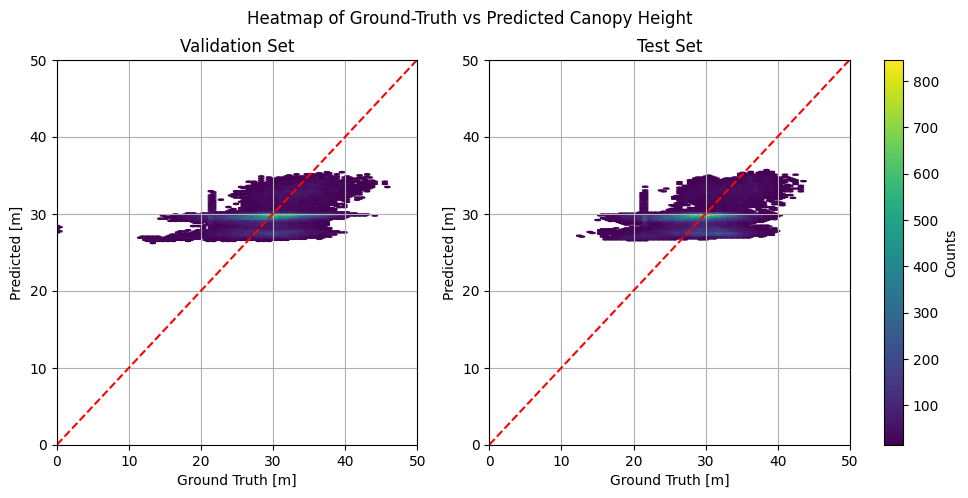

In [207]:
eval.plot_compact_heatmap_val_test(targets_val[:,0,:,:], preds_val[:,0,:,:], targets_test[:,0,:,:], preds_test[:,0,:,:], title="Heatmap of Ground-Truth vs Predicted Canopy Height\n")


In [206]:
preds_val[:,0,:,:]

array([[[29.228334, 29.195019, 29.318298, ..., 27.625126, 27.849678,
         28.368935],
        [29.231817, 29.20908 , 29.382376, ..., 26.858475, 27.1299  ,
         27.87675 ],
        [29.268469, 29.16478 , 29.35746 , ..., 26.605225, 26.798773,
         26.837229],
        ...,
        [28.213467, 27.70534 , 27.69547 , ..., 27.492243, 27.587065,
         27.685926],
        [28.322487, 27.850323, 27.838842, ..., 27.577091, 27.704319,
         27.079586],
        [28.692356, 28.366812, 27.742432, ..., 27.100689, 26.99114 ,
         26.250057]],

       [[30.783464, 30.952011, 30.785635, ..., 32.734894, 32.696148,
         32.065117],
        [31.00191 , 31.770645, 31.824152, ..., 32.94192 , 32.87419 ,
         31.767637],
        [31.321087, 32.02757 , 32.021038, ..., 32.955334, 33.128983,
         32.101448],
        ...,
        [32.383842, 33.035633, 33.60624 , ..., 30.142529, 30.254604,
         29.958284],
        [31.940338, 32.879642, 33.48127 , ..., 30.311537, 30.388004,
   